# Selecting a source from the catalog and creating a cutout image

The goal is to select a single source from the coadd measurements based on its properties and create a postage stamp image.

Based partly on:
* https://github.com/lsst-com/notebooks/blob/master/postage_stamp.ipynb

which was in turn guided by:
* https://pipelines.lsst.io/getting-started/index.html#getting-started-tutorials 
* https://github.com/RobertLuptonTheGood/notebooks/blob/master/Demos/Colour%20Images.ipynb

In [38]:
import numpy as np
import random

import lsst.daf.persistence as dafPersist
from lsst.daf.persistence import Butler
import lsst.afw.geom as afwGeom
import lsst.afw.coord as afwCoord
import lsst.afw.image as afwImage

from astropy.visualization import ZScaleInterval

In [39]:
# Set plotting defaults
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize' : (12, 8)})
zscale = ZScaleInterval()

We'll look at data from the [HSC/SSP survey](http://hsc.mtk.nao.ac.jp/ssp/), which have been processed by the LSST stack. In particular, we'll focus on the ultra-deep ("UDEEP") coadds.

In [119]:
##### If you want to edit the data set, tract, and patch yourself, change the numbers below appropriately
data_set = 'UDEEP'# HSC/SSP survey data include WIDE, DEEP, UDEEP fields
datadir = '/datasets/hsc/repo/rerun/DM-13666/' + data_set 
butler = Butler(datadir)

# We selected the "Ultra-deep (UDEEP)" data, and will choose a tract from the SXDS field (tract 8765):
tract = 8765 #8766
patch = '1,2' #'8,3'  # patch selected at random; you can select others if you like...
filt = 'HSC-G' # We'll select only a single filter for now.
dataid = {'filter': filt, 'tract':tract, 'patch':patch}

deep_coadd = butler.get('deepCoadd_forced_src', dataId=dataid)

### Read in the source catalog and the calibrated exposure

We'll use the `deepCoadd_forced_src` catalog, which contains forced photometry.

In [148]:
# Source catalog:
my_src = butler.get('deepCoadd_forced_src', dataId=dataid)

# Calibrated exposure:
my_calexp = butler.get('deepCoadd_calexp', dataId=dataid)

# Extract the WCS and the calib object:
my_wcs = my_calexp.getWcs()
my_calib = my_calexp.getCalib()
my_calib.setThrowOnNegativeFlux(False) # For magnitudes

# Finally, get the reference table for the coadd sources:
my_src_ref = butler.get('deepCoadd_ref', dataId=dataid)

# To see the names of columns in this table, use:
# my_src_ref.schema.getNames()

The cell below takes advantage of slots defined in the schema.

The `getMagnitude` function below can return some `nan` and `inf` values. In the category of "best practices", we are suggesting that these _not_ be replaced with sentinel values, but rather that one filter the arrays when needed. (We achieve this with the `okmag` filter below.)

Text(0,0.5,'PSF - Model Magnitude')

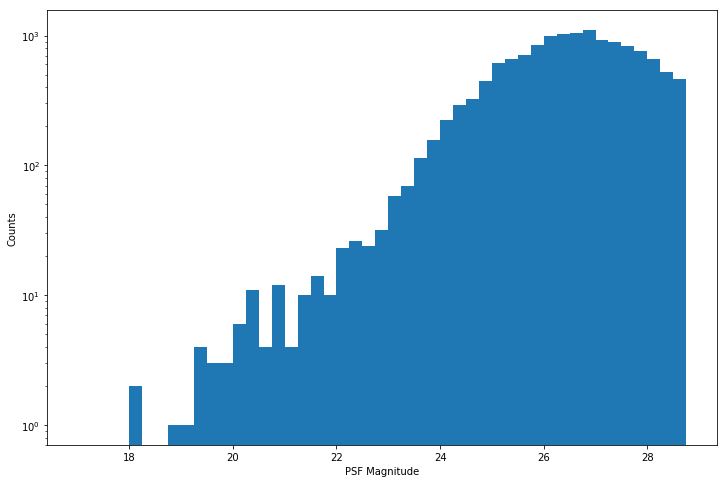

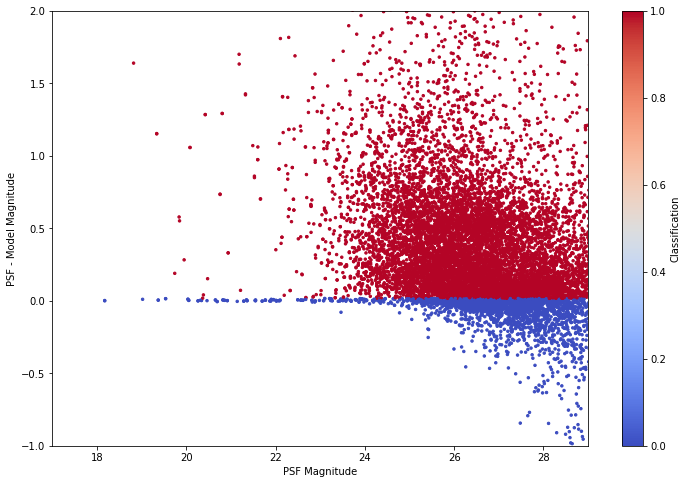

In [150]:
# Data values can be accessed using explicit references (e.g., my_src['base_PsfFlux_flux'] for the PSF flux), 
# or the slot functionality that is built into the stack (e.g., my_src.getPsfFlux()). 

## This is just a demonstration of the slot functionality (uncomment to see result):
#np.testing.assert_equal(my_calib.getMagnitude(my_src['base_PsfFlux_flux']),
#                        my_calib.getMagnitude(my_src.getPsfFlux()))

# Extract the PSF flux, then calculate the PSF magnitude using the calib object:
psf_mag = my_calib.getMagnitude(my_src.getPsfFlux())

# Extract the CModel flux, then calculate the CModel magnitude using the calib object:
cm_mag = my_calib.getMagnitude(my_src.getModelFlux())

# Select only the objects that don't have NaN values in their mags:
okmag = (np.isfinite(psf_mag)) & (np.isfinite(cm_mag))

# Distribution of PSF magnitudes:
# If you have nan or inf values in your array, use the range argument to avoid searching for min and max
plt.figure()
plt.yscale('log', nonposy='clip')
plt.hist(psf_mag[okmag], bins=np.arange(17., 29., 0.25), range=(17., 29.))
#plt.hist(np.nan_to_num(psf_mag), bins=np.arange(15., 26., 0.25)) # Alternative
plt.xlabel('PSF Magnitude')
plt.ylabel('Counts')

# Difference between PSF and model mags, which is often used as a star/galaxy separation criterion. 
# Here we color-code by the stack's classification (0=Star, 1=Galaxy (extended source))
plt.figure()
plt.scatter(psf_mag[okmag], psf_mag[okmag] - cm_mag[okmag], c=my_src['base_ClassificationExtendedness_value'][okmag], cmap='coolwarm', s=6)
plt.colorbar().set_label('Classification')
plt.xlim(17., 29.)
plt.ylim(-1., 2.)
plt.xlabel('PSF Magnitude')
plt.ylabel('PSF - Model Magnitude')

Now select a source based on its properties, e.g., pick a bright star

In [323]:
# Pick a bright star candidate
#mask = ~np.isfinite(psf_mag) | (my_src['base_ClassificationExtendedness_value'] == 1)
#index = np.argmin(np.ma.masked_array(psf_mag, mask))

# Pick a bright star that was used to fit the PSF:
selection = my_src_ref['calib_psfUsed'] & np.isfinite(psf_mag) # Also require the PSF mag to not be NaN

# Pick one of the PSF stars at random:
sel_ind = np.where(selection)
ind0 = random.choice(np.arange(np.size(sel_ind)))
index = sel_ind[0][ind0]

#index = np.argmin(np.ma.masked_array(psf_mag, selection)) # this selects the brightest of the PSF stars
#index = np.argmin(np.ma.masked_array(psf_mag, ~selection))

print('Magnitude of selected star: ',psf_mag[index])
#print(index)

ra_target, dec_target = my_src['coord_ra'][index], my_src['coord_dec'][index] # Radians
#print(dir(afwCoord))
#print(dir(afwGeom))
#print(help(afwGeom.Point2D))
#coord = afwCoord.Coord(ra_target * afwGeom.degrees, dec_target * afwGeom.degrees)
#coord = afwGeom.Point2D(ra_target * afwGeom.degrees, dec_target * afwGeom.degrees)
radec = afwGeom.SpherePoint(ra_target, dec_target, afwGeom.radians) # Is this really the preferred way to do this?

#xy = afwGeom.PointI(my_wcs.skyToPixel(radec)) # This converts to integer
#xy = afwGeom.Point2D(my_wcs.skyToPixel(radec))
#xy = my_wcs.skyToPixel(radec)
#print('sdss', my_src['base_SdssCentroid_x'][index], my_src['base_SdssCentroid_y'][index])
#print('naive', my_src['base_NaiveCentroid_x'][index], my_src['base_NaiveCentroid_y'][index])
#print('gauss', my_src['base_GaussianCentroid_x'][index], my_src['base_GaussianCentroid_y'][index])
#print('radec', xy.getX(), xy.getY())
#print(xy)
#dir(my_wcs)
#xy = my_wcs.skyToPixel(radec)

#print(ra_target, dec_target)
#print(my_wcs.skyToPixel(radec).getX())
#print(my_src.getX()[index])

## Equivalence check
#assert my_src.getX()[index] == my_src['base_SdssCentroid_x'][index]

Magnitude of selected star:  21.866753464129616


In [326]:
cutoutSize = afwGeom.ExtentI(200, 200)
#my_wcs.skyToPixel(coord)
xy = afwGeom.Point2I(my_wcs.skyToPixel(radec))

bbox = afwGeom.Box2I(xy - cutoutSize//2, cutoutSize)
#print(bbox)
#print(dir(my_calexp))
#print(help(butler.get))
#my_calexp.getBBox()

# Full patch image
image = butler.get('deepCoadd_calexp', immediate=True, dataId=dataid) #.getMaskedImage()
# Because an entire tract shares a WCS, the corner of the patch (or cutout) isn't necessarily at (X,Y)=(0,0). Get the XY0 pixel values:
xy0 = image.getXY0() 

# Postage stamp image only
cutout_image = butler.get('deepCoadd_calexp_sub', bbox=bbox, immediate=True, dataId=dataid).getMaskedImage()
# Because an entire tract shares a WCS, the corner of the patch (or cutout) isn't necessarily at (X,Y)=(0,0). Get the XY0 pixel values:
xy0_cutout = cutout_image.getXY0() 

### Plot the image of the entire patch:

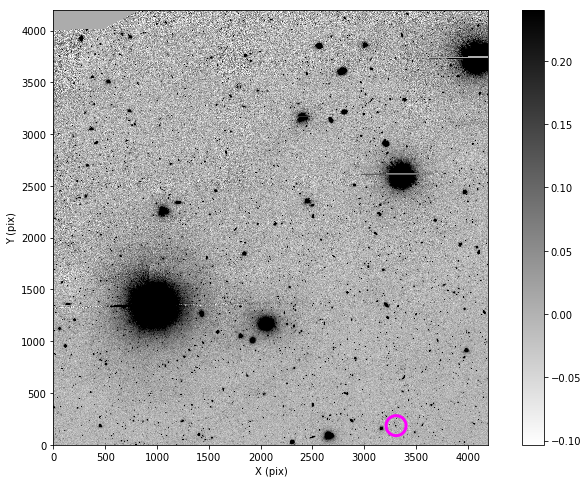

In [400]:
vmin, vmax = zscale.get_limits(image.image.array)
# Get the dimensions of the image so we can set plot limits
imsize = image.getDimensions()
plt.imshow(image.image.array, vmin=vmin, vmax=vmax, cmap='binary')
# Set the plot range to the dimensions:
plt.xlim(0,imsize[0])
plt.ylim(0,imsize[1])
plt.colorbar()
plt.xlabel('X (pix)')
plt.ylabel('Y (pix)')
#dir(xy)
plt.scatter(xy.getX()-xy0.getX(), xy.getY()-xy0.getY(), color='none', edgecolor='magenta', s=400, linewidth=3)
#my_calexp.image.array

### Plot the image of the cutout:

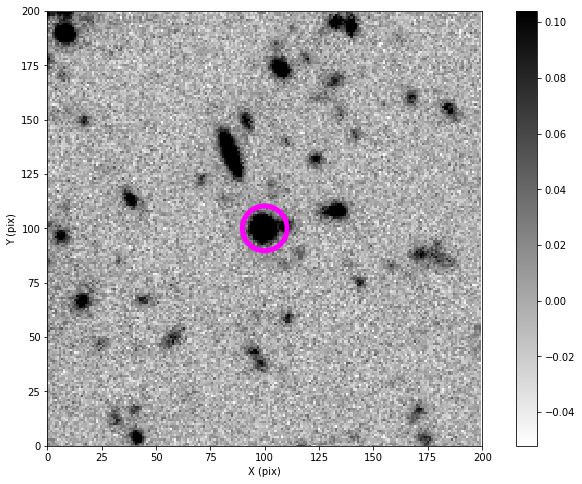

In [401]:
vmin, vmax = zscale.get_limits(cutout_image.image.array)
# Get the dimensions of the image so we can set plot limits
imsize = cutout_image.getDimensions()
plt.imshow(cutout_image.image.array, vmin=vmin, vmax=vmax, cmap='binary')
# Set the plot range to the dimensions:
plt.xlim(0,imsize[0])
plt.ylim(0,imsize[1])
plt.colorbar()
plt.xlabel('X (pix)')
plt.ylabel('Y (pix)')
#dir(xy)
plt.scatter(xy.getX()-xy0_cutout.getX(), xy.getY()-xy0_cutout.getY(), color='none', edgecolor='magenta', s=2000, linewidth=5)
#my_calexp.image.array

### Now select nearby sources and overplot them on the image:

In [363]:
# We'll use astropy utilities for finding nearby sources:
import astropy.coordinates as coord
import astropy.units as u

In [364]:
# Export the sources as an Astropy table:
src_tab = my_src.asAstropy()

# Create an Astropy "SkyCoord" object with the coordinates of all the sources:
src_coord = coord.SkyCoord(src_tab['coord_ra'],src_tab['coord_dec'])
# Select the PSF star plotted above:
selected_src_coord = src_coord[index]

In [393]:
# Use the "separation" function for SkyCoord objects to select objects within a certain distance from the target star:

sep_arcmin = 0.2 # Desired separation in arcminutes
find_nearby = src_coord.separation(selected_src_coord) < sep_arcmin*u.arcmin
nearby_src = np.where(find_nearby & okmag) # added "okmag" to ensure only well-measured sources appear

print('Selected ',np.size(src_coord[nearby_src]),' sources')

Selected  22  sources


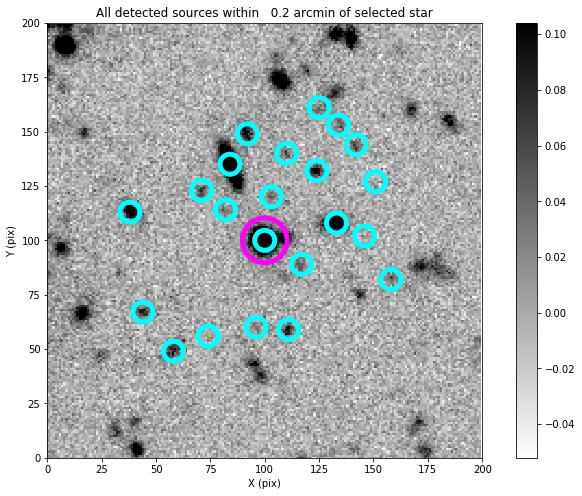

In [402]:
vmin, vmax = zscale.get_limits(cutout_image.image.array)
# Get the dimensions of the image so we can set plot limits
imsize = cutout_image.getDimensions()
plt.imshow(cutout_image.image.array, vmin=vmin, vmax=vmax, cmap='binary')
# Set the plot range to the dimensions:
plt.xlim(0,imsize[0])
plt.ylim(0,imsize[1])
plt.colorbar()
plt.xlabel('X (pix)')
plt.ylabel('Y (pix)')
plt.title(f'All detected sources within {sep_arcmin:5.2} arcmin of selected star')
#dir(xy)
plt.scatter(xy.getX()-xy0_cutout.getX(), xy.getY()-xy0_cutout.getY(), color='none', edgecolor='magenta', s=2000, linewidth=5)

for nearby in nearby_src[0]:
    ra_tmp, dec_tmp = my_src['coord_ra'][nearby], my_src['coord_dec'][nearby] # Radians
    radec_tmp = afwGeom.SpherePoint(ra_tmp, dec_tmp, afwGeom.radians)
    xy_tmp = afwGeom.Point2I(my_wcs.skyToPixel(radec_tmp))
    plt.scatter(xy_tmp.getX()-xy0_cutout.getX(), xy_tmp.getY()-xy0_cutout.getY(), color='none', edgecolor='cyan', s=400, linewidth=5)


### Challenge to the reader:
* Can you plot the image with projection (including rotation) for equatorial coordinates with RA and Dec labeled?

### Scraps:

Access schema for the source catalog to find columns of interest

In [108]:
#print(subset.cache)
#subset.cache
#butler.subset?

In [125]:
#for name in my_src.schema.getNames(): 
#    if 'centroid' in name.lower():
#        print(name)
##my_src.schema # To see slots

Show the available dataref keys for a dataset type 

Note that the `queryMetadata` and `subset` functions have similar functionality. `subset` assembles the datarefs, whereas `queryMetadata` returns a list of tuples 

In [122]:
## Display the available keys
#print(butler.getKeys('calexp'))
##print(dir(butler))
##butler.queryMetadata('calexp', butler.getKeys('calexp')) # Warning may not return in same order as getKeys()

At this point, I was tempted to name a variable "filter", but this is already a reserved word in python. Using "band" instead.

In [121]:
## Count the number of images in each filter
## Is queryMetadata faster than subset?

#visit_array, band_array = map(np.array, zip(*butler.queryMetadata('calexp', ['visit', 'filter'])))
#for band in np.unique(band_array):
#    print(band, np.sum(band_array == band))

In [120]:
## Count the number of images in each field
## Is queryMetadata faster than subset?
#visit_array, band_array = map(np.array, zip(*butler.queryMetadata('calexp', ['visit', 'field'])))
#for band in np.unique(band_array):
#    print(band, np.sum(band_array == band))


### Challenge to the reader:
* Use callback with bokeh to interactively select a source

In [324]:
## Trying to isolate some behavior here that I don't understand
## I expected the two outputs to be equal if coord_ra is computed from 'base_SdssCentroid_x'
#ra_target, dec_target = my_src['coord_ra'][index], my_src['coord_dec'][index] # Radians
#radec = afwGeom.SpherePoint(ra_target, dec_target, afwGeom.radians)
#xy = my_wcs.skyToPixel(radec)
#print(my_wcs.skyToPixel(radec).getX())
#print(my_src.getX()[index])

In [284]:
# Demonstration of equivalency
my_calexp_cutout = my_calexp.Factory(my_calexp, bbox, afwImage.LOCAL)
assert np.all(my_calexp_cutout.image.array == cutout_image.image.array)

print(cutout_image.getDimensions())
vmin, vmax = zscale.get_limits(cutout_image.image.array)
plt.imshow(cutout_image.image.array, vmin=vmin, vmax=vmax, cmap='binary')

# Does the cutout_image have a wcs? It does not appear to...
plt.scatter(xy.getX() - cutout_image.getX0(), xy.getY() - cutout_image.getY0(), c='none', edgecolor='red', s=200)

LengthError: 
  File "src/image/Image.cc", line 84, in static lsst::afw::image::ImageBase<PixelT>::_view_t lsst::afw::image::ImageBase<PixelT>::_makeSubView(const Extent2I&, const Extent2I&, const _view_t&) [with PixelT = float; lsst::afw::image::ImageBase<PixelT>::_view_t = boost::gil::image_view<boost::gil::memory_based_2d_locator<boost::gil::memory_based_step_iterator<boost::gil::pixel<float, boost::gil::layout<boost::mpl::vector1<boost::gil::gray_color_t> > >*> > >; lsst::geom::Extent2I = lsst::geom::Extent<int, 2>]
    Box2I(Point2I(6983,11064),lsst::geom::Extent2I(100,100)) doesn't fit in image 4200x4200 {0}
lsst::pex::exceptions::LengthError: 'Box2I(Point2I(6983,11064),lsst::geom::Extent2I(100,100)) doesn't fit in image 4200x4200'
